# A3TGCN

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split

In [12]:
shuffle=True
batch_size = 32

In [13]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ", len(list(dataset)))
print(next(iter(dataset)))

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x11cf62e10>
Number of samples / sequences:  34249
Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])


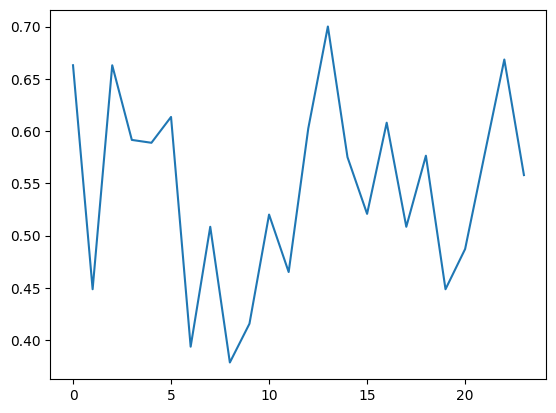

In [14]:
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
plt.plot(sensor_labels)

In [15]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", len(list(train_dataset)))
print("Number of test buckets: ", len(list(test_dataset)))

Number of train buckets:  27399
Number of test buckets:  6850


In [16]:
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor)# (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [17]:
test_input = np.array(test_dataset.features)
test_target = np.array(test_dataset.targets)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor) # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [18]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12, batch_size=2)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [19]:
model = TemporalGNN(node_features=2, periods=12, batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([12])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([12, 32])
linear.bias 	 torch.Size([12])
Net's total params: 6936
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': Non

In [20]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index
    break;

In [30]:
import torch

def calculate_mape(y_true, y_pred):
    """Calculate MAPE for PyTorch tensors"""
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

# Set model to training mode
model.train()

for epoch in range(1):
    step = 0
    loss_list = []
    mape_list = []  # List to store MAPE values
    
    for encoder_inputs, labels in train_loader:
        # Forward pass
        y_hat = model(encoder_inputs, static_edge_index)
        
        # Compute the loss (RMSE or any other loss function you're using)
        loss = loss_fn(y_hat, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Track RMSE loss
        loss_list.append(loss.item())
        
        # Calculate MAPE and append to the mape_list
        mape = calculate_mape(labels, y_hat)
        mape_list.append(mape.item())
        
        # Step counter
        step += 1
        
        # Print RMSE every 100 steps
        if step % 100 == 0:
            avg_rmse = sum(loss_list) / len(loss_list)
            avg_mape = sum(mape_list) / len(mape_list)
            print(f"Step {step}, Avg Train RMSE: {avg_rmse:.4f}, Avg Train MAPE: {avg_mape:.4f}%")
    
    # Print epoch-level statistics for RMSE and MAPE
    avg_rmse = sum(loss_list) / len(loss_list)
    avg_mape = sum(mape_list) / len(mape_list)
    print(f"Epoch {epoch}, Avg Train RMSE: {avg_rmse:.4f}, Avg Train MAPE: {avg_mape:.4f}%")


Step 100, Avg Train RMSE: 0.4652, Avg Train MAPE: 164.6146%
Step 200, Avg Train RMSE: 0.4751, Avg Train MAPE: 166.3405%
Step 300, Avg Train RMSE: 0.4729, Avg Train MAPE: 166.4487%
Step 400, Avg Train RMSE: 0.4705, Avg Train MAPE: 167.4126%
Step 500, Avg Train RMSE: 0.4674, Avg Train MAPE: 167.7944%
Step 600, Avg Train RMSE: 0.4705, Avg Train MAPE: 168.1831%
Step 700, Avg Train RMSE: 0.4689, Avg Train MAPE: 168.0078%
Step 800, Avg Train RMSE: 0.4694, Avg Train MAPE: 168.1072%
Epoch 0, Avg Train RMSE: 0.4695, Avg Train MAPE: 168.3769%


In [22]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 0.6027


In [23]:
sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


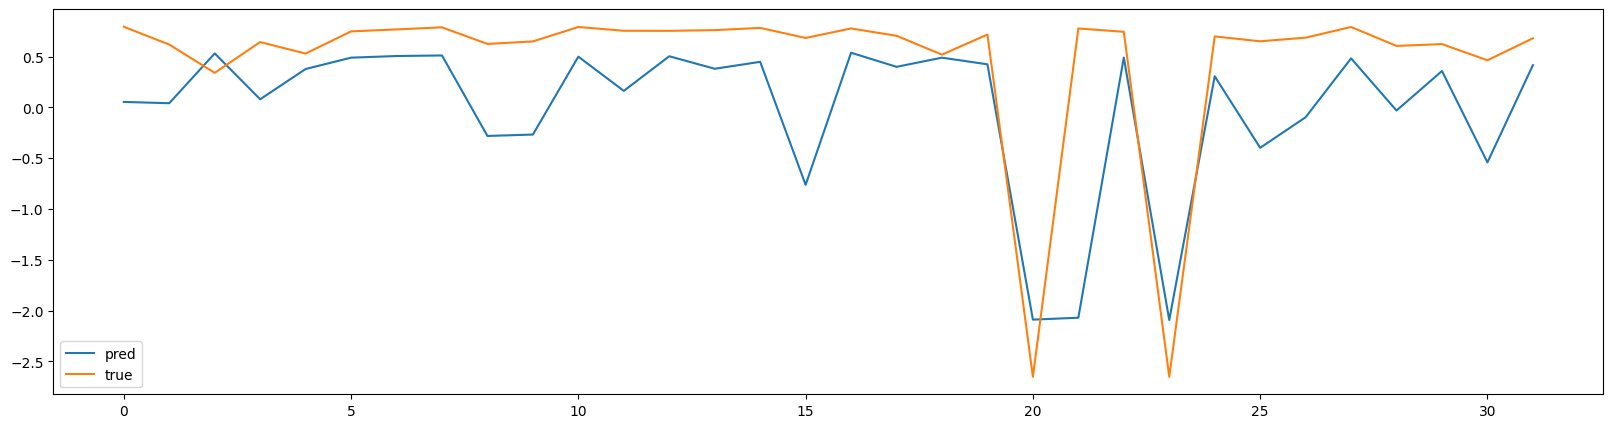

In [24]:
plt.figure(figsize=(20, 5))
plt.plot(preds, label="pred", linestyle='-', marker=None)
plt.plot(labs, label="true", linestyle='-', marker=None)


plt.legend()
plt.show()

# ASTGCN

In [2]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
from typing import Optional, List, Union
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.typing import OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import remove_self_loops, add_self_loops, get_laplacian
from torch_geometric.utils import to_dense_adj
from torch_geometric_temporal.nn.attention import ASTGCN 

In [3]:
def load_graphdata_channel1(graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size,
                            shuffle=True, DEVICE = torch.device('cuda:0')):
    '''
    :param graph_signal_matrix_filename: str
    :param num_of_hours: int
    :param num_of_days: int
    :param num_of_weeks: int
    :param DEVICE:
    :param batch_size: int
    :return:
    three DataLoaders, each dataloader contains:
    test_x_tensor: (B, N_nodes, in_feature, T_input)
    test_decoder_input_tensor: (B, N_nodes, T_output)
    test_target_tensor: (B, N_nodes, T_output)
    '''

    file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
    filename = '/Users/varun/Desktop/finalYear/code/data/PEMS04_r1_d0_w0_astcgn'

    file_data = np.load(filename + '.npz')
    train_x = file_data['train_x']  # (10181, 307, 3, 12)
    train_x = train_x[:, :, 0:1, :]
    train_target = file_data['train_target']  # (10181, 307, 12)

    val_x = file_data['val_x']
    val_x = val_x[:, :, 0:1, :]
    val_target = file_data['val_target']

    test_x = file_data['test_x']
    test_x = test_x[:, :, 0:1, :]
    test_target = file_data['test_target']

    mean = file_data['mean'][:, :, 0:1, :]  # (1, 1, 3, 1)
    std = file_data['std'][:, :, 0:1, :]  # (1, 1, 3, 1)

    # ------- train_loader -------
    train_x_tensor = torch.from_numpy(train_x).type(torch.FloatTensor)  # (B, N, F, T)
    train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor)  # (B, N, T)
    train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    # ------- val_loader -------
    val_x_tensor = torch.from_numpy(val_x).type(torch.FloatTensor)  # (B, N, F, T)
    val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor) # (B, N, T)
    val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # ------- test_loader -------
    test_x_tensor = torch.from_numpy(test_x).type(torch.FloatTensor)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor) # (B, N, T)
    test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print
    print('train:', train_x_tensor.size(), train_target_tensor.size())
    print('val:', val_x_tensor.size(), val_target_tensor.size())
    print('test:', test_x_tensor.size(), test_target_tensor.size())

    return train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, mean, std

In [4]:
graph_signal_matrix_filename = '/Users/varun/Desktop/finalYear/code/PEMS04.npz'
batch_size = 32
num_of_weeks = 0
num_of_days = 0
num_of_hours = 1

train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, _mean, _std = load_graphdata_channel1(
    graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size)

train: torch.Size([10181, 307, 1, 12]) torch.Size([10181, 307, 12])
val: torch.Size([3394, 307, 1, 12]) torch.Size([3394, 307, 12])
test: torch.Size([3394, 307, 1, 12]) torch.Size([3394, 307, 12])


In [5]:
def get_adjacency_matrix(distance_df_filename, num_of_vertices, id_filename=None):
    '''
    distance_df_filename: str, path of the csv file contains edges information
    num_of_vertices: int, the number of vertices
    Returns
    A: np.ndarray, adjacency matrix
    '''
    if 'npy' in distance_df_filename:  # false
        adj_mx = np.load(distance_df_filename)
        return adj_mx, None
    else:
        
        #--------------------------------------------- read from here
        import csv
        A = np.zeros((int(num_of_vertices), int(num_of_vertices)),dtype=np.float32)
        distaneA = np.zeros((int(num_of_vertices), int(num_of_vertices)), dtype=np.float32)

        if id_filename: # false
            with open(id_filename, 'r') as f:
                id_dict = {int(i): idx for idx, i in enumerate(f.read().strip().split('\n'))}

            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[id_dict[i], id_dict[j]] = 1
                    distaneA[id_dict[i], id_dict[j]] = distance
            return A, distaneA

        else:
            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[i, j] = 1
                    distaneA[i, j] = distance
            return A, distaneA

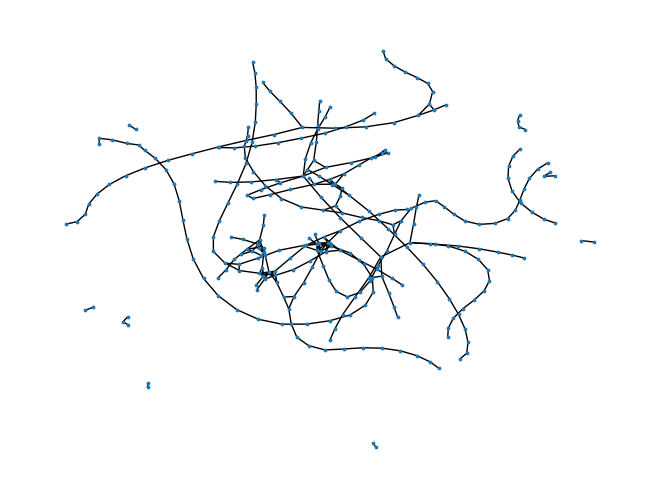

In [6]:
id_filename = None
adj_filename = '/Users/varun/Desktop/finalYear/code/data/PEMS04.csv'
num_of_vertices = 307
adj_mx, distance_mx = get_adjacency_matrix(adj_filename, num_of_vertices, id_filename) #  adj_mx and distance_mx (307, 307)

rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=3)
plt.show()
rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
edge_index_data = torch.LongTensor(np.array([rows, cols]))

In [7]:
nb_block = 2
in_channels = 1
K = 3
nb_chev_filter = 64
nb_time_filter = 64
time_strides = num_of_hours
num_for_predict = 12
len_input = 12

net = ASTGCN( nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices)

print(net)

ASTGCN(
  (_blocklist): ModuleList(
    (0): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(1, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (1): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(64, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (_final_conv): Conv2d(12, 12, kernel_size=(1, 64), strid

In [13]:
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

print('Net\'s state_dict:')
total_param = 0
for param_tensor in net.state_dict():
    print(param_tensor, '\t', net.state_dict()[param_tensor].size(), '\t', net.state_dict()[param_tensor].device)
    total_param += np.prod(net.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
_blocklist.0._temporal_attention._U1 	 torch.Size([307]) 	 cpu
_blocklist.0._temporal_attention._U2 	 torch.Size([1, 307]) 	 cpu
_blocklist.0._temporal_attention._U3 	 torch.Size([1]) 	 cpu
_blocklist.0._temporal_attention._be 	 torch.Size([1, 12, 12]) 	 cpu
_blocklist.0._temporal_attention._Ve 	 torch.Size([12, 12]) 	 cpu
_blocklist.0._spatial_attention._W1 	 torch.Size([12]) 	 cpu
_blocklist.0._spatial_attention._W2 	 torch.Size([1, 12]) 	 cpu
_blocklist.0._spatial_attention._W3 	 torch.Size([1]) 	 cpu
_blocklist.0._spatial_attention._bs 	 torch.Size([1, 307, 307]) 	 cpu
_blocklist.0._spatial_attention._Vs 	 torch.Size([307, 307]) 	 cpu
_blocklist.0._chebconv_attention._weight 	 torch.Size([3, 1, 64]) 	 cpu
_blocklist.0._chebconv_attention._bias 	 torch.Size([64]) 	 cpu
_blocklist.0._time_convolution.weight 	 torch.Size([64, 64, 1, 3]) 	 cpu
_blocklist.0._time_convolution.bias 	 torch.Size([64]) 	 cpu
_blocklist.0._residual_convolution.weight 	 torch.Size([64, 1, 1,

In [14]:
def masked_mae(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds - labels)
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)

In [15]:
masked_flag=0
criterion = nn.L1Loss()
criterion_masked = masked_mae
loss_function = 'mse'

metric_method = 'unmask'
missing_value=0.0


if loss_function=='masked_mse':
    criterion_masked = masked_mse    
    masked_flag=1
elif loss_function=='masked_mae':
    criterion_masked = masked_mae
    masked_flag = 1
elif loss_function == 'mae':
    criterion = nn.L1Loss()
    masked_flag = 0
elif loss_function == 'rmse':
    criterion = nn.MSELoss()
    masked_flag= 0

In [20]:
def compute_val_loss_mstgcn(net, val_loader, criterion, masked_flag, missing_value, epoch, edge_index_data, limit=None):
    '''
    for rnn, compute mean loss on validation set
    :param net: model
    :param val_loader: torch.utils.data.utils.DataLoader
    :param criterion: torch.nn.MSELoss
    :param epoch: int, current epoch
    :param limit: int, optional limit on number of batches to process
    :return: val_loss
    '''
    net.eval()  # ensure dropout layers are in evaluation mode
    with torch.no_grad():
        val_loader_length = len(val_loader)  # number of batches
        tmp = []  # batch loss
        for batch_index, batch_data in enumerate(val_loader):
            encoder_inputs, labels = batch_data
            outputs = net(encoder_inputs, edge_index_data)
            if masked_flag:
                loss = criterion(outputs, labels, missing_value)
            else:
                loss = criterion(outputs, labels)
            tmp.append(loss.item())
            if batch_index % 100 == 0:
                print('Validation batch %s / %s, loss: %.2f' % (batch_index + 1, val_loader_length, loss.item()))
            if (limit is not None) and batch_index >= limit:
                break

        validation_loss = sum(tmp) / len(tmp)
    return validation_loss


In [21]:
global_step = 0
best_epoch = 0
best_val_loss = np.inf
start_time= time()

In [23]:
# Train model
for epoch in range(20):
    params_filename = os.path.join('./', 'epoch_%s.params' % epoch)
    masked_flag = 1
    
    if masked_flag:
        val_loss = compute_val_loss_mstgcn(net, val_loader, criterion_masked, masked_flag, missing_value, epoch, edge_index_data)
    else:
        val_loss = compute_val_loss_mstgcn(net, val_loader, criterion, masked_flag, missing_value, epoch, edge_index_data)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch

    net.train()  # Ensure dropout layers are in train mode

    for batch_index, batch_data in enumerate(train_loader):
        encoder_inputs, labels = batch_data  # encoder_inputs torch.Size([32, 307, 1, 12]), labels torch.Size([32, 307, 12])
        optimizer.zero_grad()
        outputs = net(encoder_inputs, edge_index_data)  # torch.Size([32, 307, 12])

        if masked_flag:
            loss = criterion_masked(outputs, labels, missing_value)
        else:
            loss = criterion(outputs, labels)
            
        loss.backward()
        optimizer.step()
        training_loss = loss.item()
        global_step += 1

        if global_step % 200 == 0:
            print('Global step: %s, training loss: %.2f, time: %.2fs' % (global_step, training_loss, time() - start_time))


Validation batch 1 / 107, loss: 210.27
Validation batch 101 / 107, loss: 266.04
Global step: 200, training loss: 98.40, time: 406.07s
Global step: 400, training loss: 49.63, time: 670.38s
Validation batch 1 / 107, loss: 46.33
Validation batch 101 / 107, loss: 64.61


KeyboardInterrupt: 

# DCRNN

In [ ]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric.nn import GCNConv

In [ ]:
loader = METRLADatasetLoader()
dataset = loader.get_dataset(12,12)

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_temporal_data(train_dataset, num_sensors=5, sample =99):
    """
    Visualize the temporal data for a few sensors.
    
    Parameters:
    - train_dataset: List of Data objects containing x and y for each sample.
    - num_sensors: Number of sensors to visualize.
    - sample: timestamp to visualize
    """

    sample = train_dataset[sample]
    x = sample.x.numpy()
    y = sample.y.numpy()
    
    # Plot temporal data for the selected number of sensors
    for sensor_id in range(min(num_sensors, x.shape[0])):
        plt.figure(figsize=(10, 4))
        plt.plot(range(1, 13), x[sensor_id][0], marker='o', label='Input (Last 12 Timestamps)')
        plt.plot(range(13, 25), y[sensor_id, :], marker='x', label='Target (Next 12 Timestamps)')
        plt.title(f"Sensor {sensor_id + 1}: Temporal Data Visualization")
        plt.xlabel("Timestep")
        plt.ylabel("Sensor Value")
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
visualize_temporal_data(train_dataset, num_sensors=3)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric_temporal.nn.recurrent import DCRNN

class DCRNNModel(nn.Module):
    def __init__(self, in_channels, out_channels, K, num_nodes, horizon):
        super(DCRNNModel, self).__init__()
        self.dcrnn = DCRNN(in_channels, 32, K)
        # self.dcrnn2 = DCRNN(32, 64, K)
        # self.dcrnn3 = DCRNN(64, 32, K)
        # self.dcrnn4 = DCRNN(32, horizon, K)
        # self.spatial = GCNConv(in_channels=in_channels, out_channels=out_channels)
        self.fc = nn.Linear(32, horizon)
    
    def forward(self, x, edge_index, edge_weight):
        # x: Node features (in_channels, num_nodes)
        # edge_index: Graph connectivity (2, num_edges)
        h = self.dcrnn(x, edge_index, edge_weight).relu()
        # h = self.dcrnn2(h, edge_index, edge_weight).relu()
        # h = self.dcrnn3(h, edge_index, edge_weight).relu()
        # out = self.dcrnn4(h, edge_index, edge_weight).relu()
        # h = self.spatial(x, edge_index, edge_weight)
        out = self.fc(h)
        return out


In [36]:
def train(model, train_dataset, optimizer, criterion, num_epochs=20):
    model.train()
    loss_values = []
    for epoch in range(num_epochs):
        total_loss = 0
        for time, snapshot in enumerate(train_dataset):
            x, edge_index, y, edge_weight = snapshot.x[:,0], snapshot.edge_index, snapshot.y, snapshot.edge_weight
            optimizer.zero_grad()
            out = model(x, edge_index, edge_weight)
            # print(len(out))
            # print('---------------------------------------------------------------------------------------------')
            # print(len(y))
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_values.append(total_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")
    return loss_values
    

In [37]:
# Hyperparameters
in_channels = 12
out_channels = 12
K = 1
num_nodes = 207
horizon = 12

model = DCRNNModel(in_channels, out_channels, K, num_nodes, horizon)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train the model
loss_values = train(model, train_dataset, optimizer, criterion, num_epochs=20)

Epoch 1/20, Loss: 8770.6663
Epoch 2/20, Loss: 9299.9841
Epoch 3/20, Loss: 8708.3383
Epoch 4/20, Loss: 8662.9198
Epoch 5/20, Loss: 8582.7076
Epoch 6/20, Loss: 8624.5860
Epoch 7/20, Loss: 8550.8066
Epoch 8/20, Loss: 8695.9534
Epoch 9/20, Loss: 9068.6207
Epoch 10/20, Loss: 8906.6924
Epoch 11/20, Loss: 8557.0432
Epoch 12/20, Loss: 8803.4507
Epoch 13/20, Loss: 8578.6421
Epoch 14/20, Loss: 9549.2213
Epoch 15/20, Loss: 8696.7978
Epoch 16/20, Loss: 9198.3878
Epoch 17/20, Loss: 8749.6521
Epoch 18/20, Loss: 8747.3587
Epoch 19/20, Loss: 8491.6607
Epoch 20/20, Loss: 8679.7486


In [38]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def visualize_forecast(test_dataset, model, train_dataset, num_sensors=5, sample=99):
    """
    Visualize the temporal training data (x), actual data (y), and the forecasted value.
    
    Parameters:
    - test_dataset: The dataset used for testing, should contain x and y.
    - model: The trained forecasting model.
    - train_dataset: The dataset used for training, to show historical data.
    - num_sensors: Number of sensors to visualize.
    - sample: Index of the sample to visualize from the test dataset.
    """
    for idx, snapshot in enumerate(test_dataset):
        ground_truth = []
        predictions = []
        
        # Extract data for the given sample
        x_sample = test_dataset[idx].x[:, 0]
        y_actual = test_dataset[idx].y
        edge_index = test_dataset[idx].edge_index
        edge_weight = test_dataset[idx].edge_weight
    
        # Model prediction
        with torch.no_grad():
            model.eval()
            y_pred = model(x_sample, edge_index, edge_weight)
            predictions.append(y_pred)
            ground_truth.append(y_actual)
    
        # Calculate MAE (Mean Absolute Error)
        mae = F.l1_loss(y_pred, y_actual)
        
        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = torch.mean(torch.abs((y_actual - y_pred) / y_actual)) * 100
        
        # Calculate RMSE (Root Mean Squared Error)
        rmse = torch.sqrt(F.mse_loss(y_pred, y_actual))
    
    # Print or display the scores
    print(f"Sample {sample} - MAE: {mae.item():.4f}, MAPE: {mape.item():.2f}%, RMSE: {rmse.item():.4f}")

    # Plotting
    fig, axs = plt.subplots(num_sensors, 1, figsize=(10, 5 * num_sensors), sharex=True)
    
    if num_sensors == 1:
        axs = [axs]  # Make axs iterable if there's only one sensor

    for i in range(num_sensors):
        # Plot all data on the same subplot
        # axs[i].plot(train_dataset[sample].x[i, 0], label='Training Data', linestyle='--', color='gray')
        axs[i].plot(y_actual[i].numpy(), label='Actual Data', color='blue')
        axs[i].plot(y_pred[i].numpy(), label='Forecasted Data', color='red')
        
        axs[i].set_title(f'Sensor {i}')
        axs[i].legend()

    # Display the metrics on the plot
    plt.suptitle(f'Sample {sample} - MAE: {mae.item():.4f}, MAPE: {mape.item():.2f}%, RMSE: {rmse.item():.4f}', fontsize=16)
    
    plt.xlabel('Time Steps')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.show()
    return ground_truth, predictions
# Example usage:
# visualize_forecast(test_dataset, model_STGCN, train_dataset, num_sensors=15)


Sample 0 - MAE: 0.2262, MAPE: 122.95%, RMSE: 0.3461


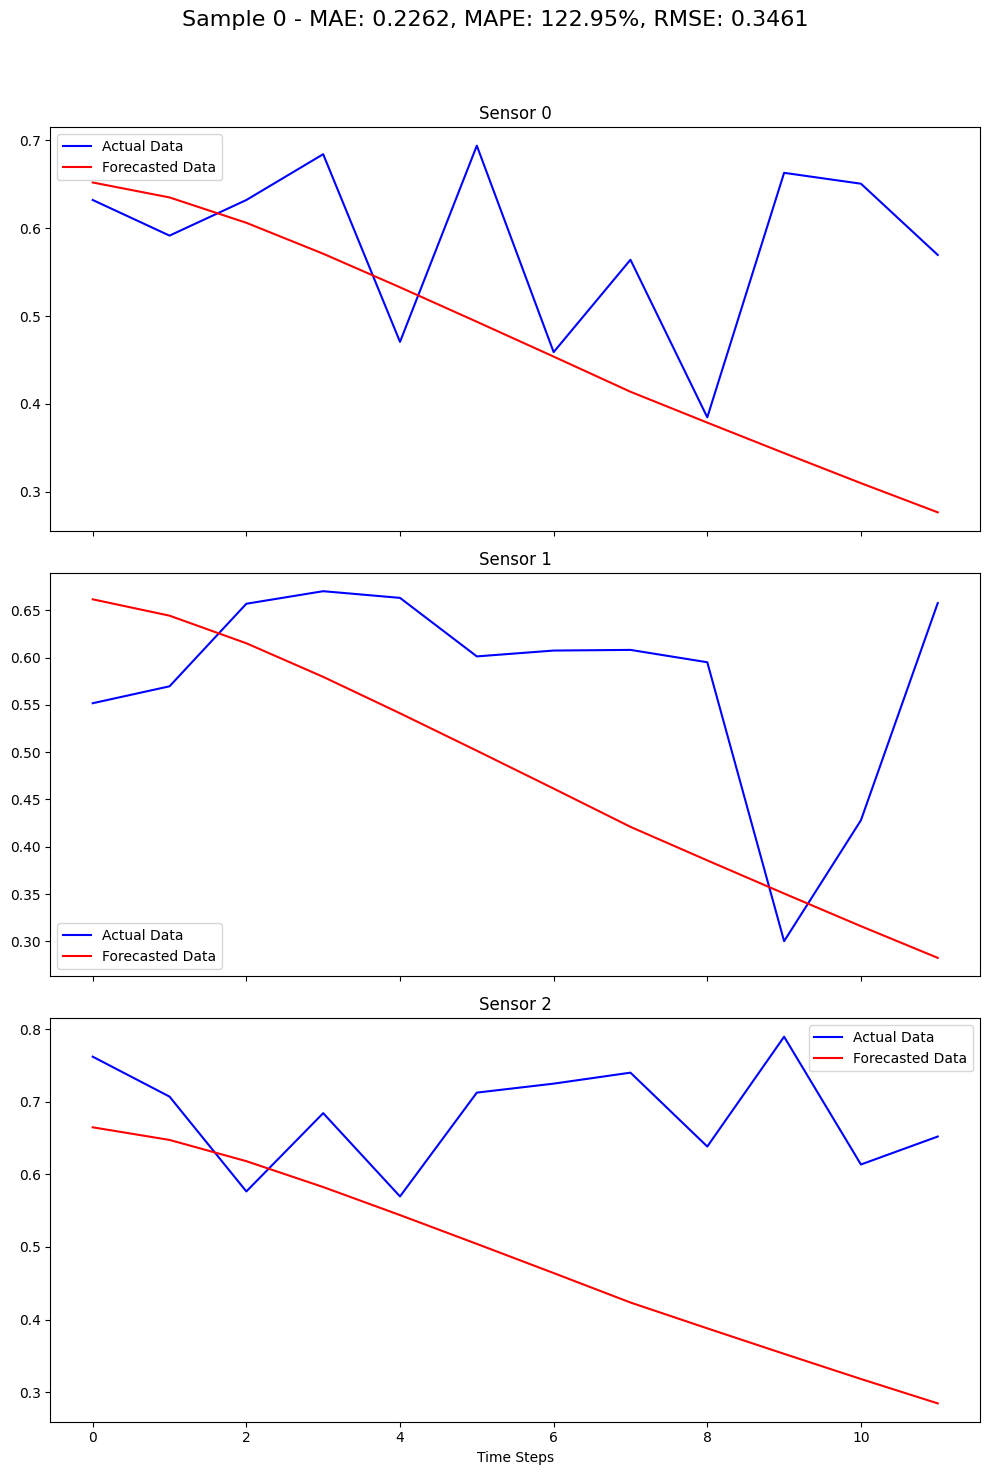

In [42]:
ground_truth, predictions=visualize_forecast(test_dataset, model, train_dataset, num_sensors = 3, sample = 0)